# Transfer learning

We are familiar with the small convolutional
network we trained on MNIST.

Let's look again at these images

![](./figs/mnist.png)


We now repurpose it to do another task:
recognizing the following shapes

![](./figs/kmnist.png)

These are Japanese Kanji!

(related paper here https://arxiv.org/abs/1812.01718)

The characteristics of this dataset is that

- it is more complex than MNIST 
  (more complex shapes, more variability)
  
- it has 10 categories like MNIST

So we can hope that some part of the network we trained
on MNIST will be helpful also for this problem.







We also address the following question:
- how different are the two datasets?

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

import numpy as np
from matplotlib import pyplot as plt

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [4]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [5]:
input_size=(1,28,28,)
batch_size=64
test_batch_size=1000
seed=1101

In [6]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [9]:
train_loader = torch.utils.data.DataLoader(
        datasets.KMNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
        datasets.KMNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=test_batch_size, shuffle=True, **kwargs)

In [10]:
model = Net().to(device)

In [11]:
summary(model,input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
            Conv2d-2             [-1, 50, 8, 8]          25,050
            Linear-3                  [-1, 500]         400,500
            Linear-4                   [-1, 10]           5,010
Total params: 431,080
Trainable params: 431,080
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 1.64
Estimated Total Size (MB): 1.76
----------------------------------------------------------------


In [12]:
model.load_state_dict(torch.load('mnist_cnn.pt'))
model.eval()

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [13]:
inputs,labels = next(iter(test_loader))

In [14]:
inputs.shape

torch.Size([1000, 1, 28, 28])

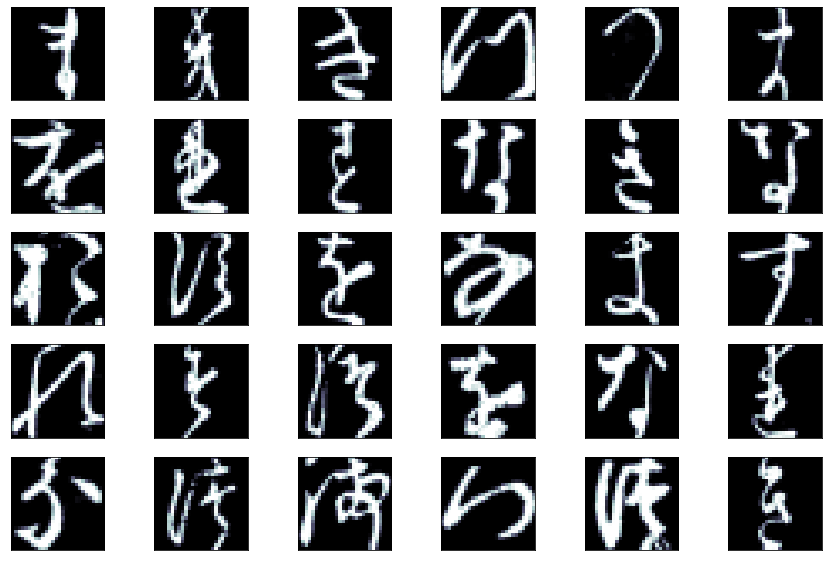

In [15]:
fig=plt.figure(figsize=(15,10))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.imshow(np.squeeze(inputs[i]),cmap='bone')
    plt.xticks([])
    plt.yticks([])

In [16]:
output = model(inputs)
pred = output.argmax(dim=1, keepdim=True) 
correct = pred.eq(labels.view_as(pred)).sum().item()
print('acc = {}'.format(correct/inputs.shape[0]) )

acc = 0.111


In [15]:
# ... from our Net class
#self.fc1 = nn.Linear(4*4*50, 500)
#self.fc2 = nn.Linear(500, 10)

In [17]:
for p in model.parameters():
    print(p.shape)

torch.Size([20, 1, 5, 5])
torch.Size([20])
torch.Size([50, 20, 5, 5])
torch.Size([50])
torch.Size([500, 800])
torch.Size([500])
torch.Size([10, 500])
torch.Size([10])


In [18]:
for p in model.parameters():
    p.requires_grad = False

In [19]:
list(model.parameters())[-2]

Parameter containing:
tensor([[ 0.0361,  0.0205,  0.0401,  ..., -0.0451,  0.0030, -0.0106],
        [ 0.0502,  0.0349, -0.0195,  ...,  0.0468, -0.0002,  0.0350],
        [-0.0270,  0.0156,  0.0186,  ...,  0.0710, -0.0811, -0.0227],
        ...,
        [ 0.0375,  0.0532,  0.0075,  ...,  0.0292, -0.0197,  0.0389],
        [-0.0465, -0.0326, -0.0160,  ...,  0.0161,  0.0264, -0.0259],
        [-0.0290,  0.0244,  0.0123,  ..., -0.0422, -0.0234, -0.0208]])

In [20]:
model.fc2 = nn.Linear(500,10)

In [21]:
for p in model.parameters():
    print(p.requires_grad)

False
False
False
False
False
False
True
True


In [22]:
list(model.parameters())[-2]

Parameter containing:
tensor([[ 0.0366,  0.0352, -0.0173,  ..., -0.0274, -0.0154,  0.0139],
        [-0.0175, -0.0045, -0.0267,  ...,  0.0172,  0.0135, -0.0415],
        [-0.0114, -0.0396, -0.0021,  ..., -0.0027,  0.0084,  0.0194],
        ...,
        [ 0.0349, -0.0118, -0.0166,  ...,  0.0075, -0.0035,  0.0041],
        [-0.0396, -0.0089, -0.0092,  ...,  0.0109,  0.0206,  0.0261],
        [ 0.0370,  0.0347, -0.0089,  ..., -0.0034,  0.0424,  0.0187]],
       requires_grad=True)

In [23]:
for p in model.parameters():
    print(p.shape,p.requires_grad)

torch.Size([20, 1, 5, 5]) False
torch.Size([20]) False
torch.Size([50, 20, 5, 5]) False
torch.Size([50]) False
torch.Size([500, 800]) False
torch.Size([500]) False
torch.Size([10, 500]) True
torch.Size([10]) True


In [24]:
epochs=10
lr=0.01
momentum=0.0
seed=1
log_interval=100
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
save=False

In [25]:
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    
if save:
    torch.save(model.state_dict(),"kmnist_trans_fc2.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.531272
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.023822
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.881309
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.645791
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.785615
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.636878
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.616144
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.460627
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.617484
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.562121

Test set: Average loss: 0.9416, Accuracy: 7097/10000 (71%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.491891
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.483190
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.462455
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.432000
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.604765
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.391859
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.617878
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.531499
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.564846
T

# Exercise



Experiment *freely* with these topics.
This will not be a guided exercise, maybe just some part.

Experimenting with these problems is a good starting
point to do more serious applcations later!


- extension of random initialization to the second last hidden layer
- monitor test and train loss and accuracy: does the model overfit?
- change learning rate and/or momentum
- regularize it with dropout (*)

(*) You will have to redefine the Net class, adding the dropout layers after the feature extractions (after the second max pooling layer) and after fully connected fc1. Take inspiration from this architecture https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py (which is written in Keras, by the way). Then you have to re-train the model on MNIST and experiment again with transfer learning on KMNIST.

# Intrinsic dimensionality

Let's see how different these two datasets are. 

We will look at their intrinsic dimensionality (ID) which is
basically the number of truly independent coordinates
that describe the data manifold with minimal information
loss.

We will estimate the intrinsic dimensionality with the algorithm in https://www.nature.com/articles/s41598-017-11873-y


Question: are you able to make these guesses?

- what is the ID of MNIST? 
- and that of KMNIST?

In [26]:
nsamples=5000
sampleKMNISTloader = torch.utils.data.DataLoader(
        datasets.KMNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=nsamples, shuffle=True, **kwargs)

sampleMNISTloader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=nsamples, shuffle=True, **kwargs)

In [27]:
sample_kmnist,_ = next(iter(sampleKMNISTloader))
sample_mnist,_ = next(iter(sampleMNISTloader))

In [29]:
from intrinsic_dimension import estimate,block_analysis

In [30]:
print(sample_kmnist.shape)
print(sample_mnist.shape)

torch.Size([5000, 1, 28, 28])
torch.Size([5000, 1, 28, 28])


In [31]:
sample_kmnist = np.reshape(np.squeeze(sample_kmnist), (nsamples, -1) )
sample_mnist = np.reshape(np.squeeze(sample_mnist), (nsamples, -1) )

In [32]:
from scipy.spatial.distance import pdist,squareform

In [37]:
?estimate

Signature: estimate(X, fraction=0.9, verbose=True)
Docstring:
Estimates the intrinsic dimension of a system of points from
the matrix of their distances X

Args:
X : 2-D Matrix X (n,n) where n is the number of points
fraction : fraction of the data considered for the dimensionality
estimation (default : fraction = 0.9)
Returns:            
x : log(mu)    (*)
y : -(1-F(mu)) (*)
reg : linear regression y ~ x structure obtained with scipy.stats.linregress
(reg.slope is the intrinsic dimension estimate)
r : determination coefficient of y ~ x
pval : p-value of y ~ x
    
(*) See cited paper for description

Usage:
    
_,_,reg,r,pval = estimate(X,fraction=0.85)
    
The technique is described in : 
    
"Estimating the intrinsic dimension of datasets by a 
minimal neighborhood information"       
Authors : Elena Facco, Maria d’Errico, Alex Rodriguez & Alessandro Laio        
Scientific Reports 7, Article number: 12140 (2017)
doi:10.1038/s41598-017-11873-y
File:      c:\users\ansuini\dropbox

In [33]:
kmnist_est = estimate(squareform(pdist(sample_kmnist)), verbose=True)
mnist_est = estimate(squareform(pdist(sample_mnist)), verbose=True)

Found n. 0 elements for which r1 = 0
[]
Found n. 0 elements for which r1 = r2
[]
Fraction good points: 1.0
Found n. 0 elements for which r1 = 0
[]
Found n. 0 elements for which r1 = r2
[]
Fraction good points: 1.0


In [34]:
print(kmnist_est[2])

16.950413573166053


In [35]:
print(mnist_est[2])

12.82621314219116


In [36]:
?block_analysis

Signature:
block_analysis(
    X,
    blocks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    fraction=0.9,
)
Docstring:
Perform a block-analysis of a system of points from
the matrix of their distances X

Args:
X : 2-D Matrix X (n,n) where n is the number of points
blocks : blocks specification, is a list of integers from
1 to N_blocks where N_blocks is the number of blocks (default : N_blocks = 20)
fraction : fraction of the data considered for the dimensionality
estimation (default : fraction = 0.9)
File:      c:\users\ansuini\dropbox\coursesonline\mhpc_dl_2020\day2\intrinsic_dimension.py
Type:      function


In [38]:
kmnist_ba = block_analysis(squareform(pdist(sample_kmnist)))
mnist_ba = block_analysis(squareform(pdist(sample_mnist)))

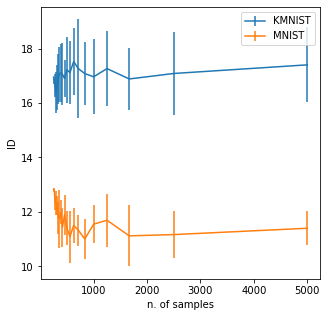

In [39]:
fig=plt.figure(figsize=(5,5))
plt.errorbar(kmnist_ba[2][::-1],kmnist_ba[0],yerr=kmnist_ba[1],label='KMNIST')
plt.errorbar(mnist_ba[2][::-1],mnist_ba[0],yerr=mnist_ba[1],label='MNIST')
plt.xlabel('n. of samples')
plt.ylabel('ID')
plt.legend()
plt.savefig('KMNIST_ID.png')
plt.show()

# Further Readings

- https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
- https://towardsdatascience.com/getting-started-with-google-colab-f2fff97f594c

# Exercise (optional)

This is an anticipation on what we will see with Cristiano De Nobili that
will use colab

- run the notebook on colab and play with it